# The CHSH game

In [4]:
# Required imports

from qiskit import QuantumCircuit
from qiskit_aer.primitives import Sampler
from numpy import pi
from numpy.random import randint

The CSHS game is a *gedanken* experiment in which two actors, Alice and Bob, have to generate a question for the other and simultáneously guess the answer of each question. We can represent this game by bits of information as follows:

x is Alice's question, y is Bob's question, a is Alice's answer, and b is Bob's answer:

- The questions and answers are all bits: $x,y,a,b∈{0,1}$.

- The referee chooses the questions $(x,y)$ uniformly at random. That is, each of the four possibilities, $(0,0)$, $(0,1)$, $(1,0)$, and $(1,1)$, is selected with probability $1/4$.

- The answers $(a,b)$ win for the questions $(x,y)$ if $a⊕b=x∧y$ and lose otherwise. Essentially, they win the game when for $(0,0)$, $(0,1)$ and $(1,0)$ they guess $a=b$ or when they guess $a\neq b$ for $(1,1)$.

Classically, the overall probability for them to win the game is $3/4$. This is irrespective of using a deterministic or a probabilistic strategy. 

Here, we build the quantum protocol that exploits a quantum strategy beating this probability limit. This is yet another demonstration of entanglement that has no classical explanation whatsoever. 


In [5]:
# We first define the game 

def chsh_game(strategy):
    """Plays the CHSH game
    Args:
        strategy (callable): A function that takes two bits (as `int`s) and
            returns two bits (also as `int`s). The strategy must follow the
            rules of the CHSH game.
    Returns:
        int: 1 for a win, 0 for a loss.
    """
    # Referee chooses x and y randomly
    x, y = randint(0, 2), randint(0, 2)

    # Use strategy to choose a and b
    a, b = strategy(x, y)

    # Referee decides if Alice and Bob win or lose
    if (a != b) == (x & y):
        return 1  # Win
    return 0  # Lose

We need function that outputs a circuit depending on the questions for Alice and Bob. We shall name the qubits with their default game names for simplicity, and we'll use the built-in $R_y(θ)$ gate for Alice and Bob's actions.

In [6]:
def chsh_circuit(x, y):
    """Creates a `QuantumCircuit` that implements the best CHSH strategy.
    Args:
        x (int): Alice's bit (must be 0 or 1)
        y (int): Bob's bit (must be 0 or 1)
    Returns:
        QuantumCircuit: Circuit that, when run, returns Alice and Bob's
            answer bits.
    """
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.barrier()

    # Alice
    if x == 0:
        qc.ry(0, 0)
    else:
        qc.ry(-pi / 2, 0)
    qc.measure(0, 0)

    # Bob
    if y == 0:
        qc.ry(-pi / 4, 1)
    else:
        qc.ry(pi / 4, 1)
    qc.measure(1, 1)

    return qc

(x,y) = (0,0)


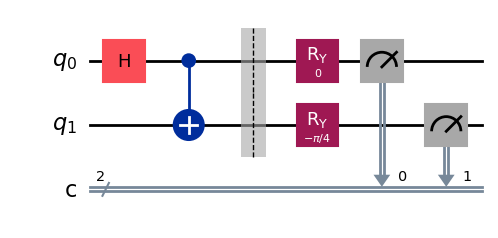

(x,y) = (0,1)


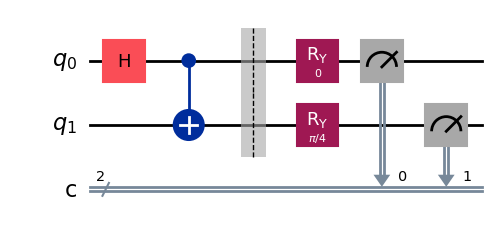

(x,y) = (1,0)


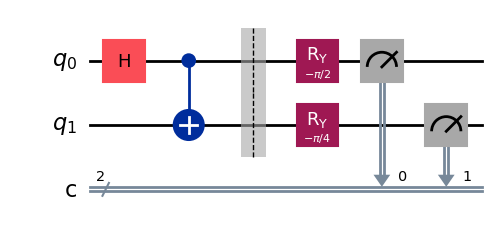

(x,y) = (1,1)


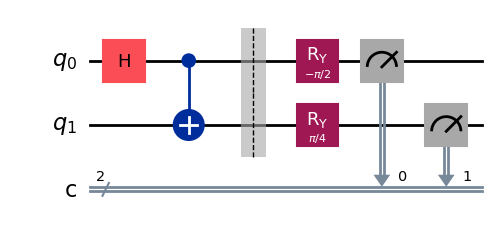

In [7]:
# Let's display the four possible circuits

# Draw the four possible circuits

print("(x,y) = (0,0)")
display(chsh_circuit(0, 0).draw('mpl'))

print("(x,y) = (0,1)")
display(chsh_circuit(0, 1).draw('mpl'))

print("(x,y) = (1,0)")
display(chsh_circuit(1, 0).draw('mpl'))

print("(x,y) = (1,1)")
display(chsh_circuit(1, 1).draw('mpl'))

Let's use the Aer sampler to extract the statistics of the CHSH game

In [8]:
# It might be useful to have a function that plays the game for each quantum strategy

sampler = Sampler()

def quantum_strategy(x, y):
    """Carry out the best strategy for the CHSH game.
    Args:
        x (int): Alice's bit (must be 0 or 1)
        y (int): Bob's bit (must be 0 or 1)
    Returns:
        (int, int): Alice and Bob's answer bits (respectively)
    """
    # `shots=1` runs the circuit once
    result = sampler.run(chsh_circuit(x, y), shots=1).result()
    statistics = result.quasi_dists[0].binary_probabilities()
    bits = list(statistics.keys())[0]
    a, b = bits[0], bits[1]
    return a, b

We play the game 1000 times. We then compute the fraction of games that Alice and Bob have won with respect to the total number of attempts.

In [12]:
NUM_GAMES = 1000
TOTAL_SCORE = 0

for _ in range(NUM_GAMES):
    TOTAL_SCORE += chsh_game(quantum_strategy)

print("Fraction of games won:", TOTAL_SCORE / NUM_GAMES)

Fraction of games won: 0.86


If we run the game over and over, we shall see the fraction of games won slightly fluctuating around 0.85

Text(0, 0.5, 'Fraction of games won')

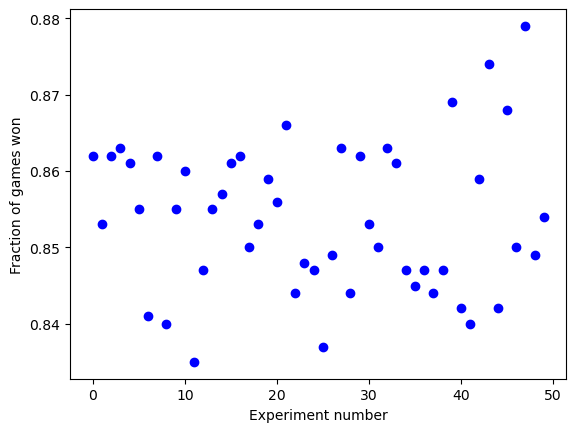

In [18]:
import matplotlib.pyplot as plt

for k in range(50):
    TOTAL_SCORE = 0
    for _ in range(NUM_GAMES):
        TOTAL_SCORE += chsh_game(quantum_strategy)
    plt.plot(k, TOTAL_SCORE / NUM_GAMES, 'bo')
    
plt.xlabel('Experiment number')
plt.ylabel('Fraction of games won')

For more coding fun and comparison, let us try what we obtain with a classical strategy.

In [19]:
# We define an optimal classical strategy for the CHSH game

def classical_strategy(x, y):
    """An optimal classical strategy for the CHSH game
    Args:
        x (int): Alice's bit (must be 0 or 1)
        y (int): Bob's bit (must be 0 or 1)
    Returns:
        (int, int): Alice and Bob's answer bits (respectively)
    """
    # Alice's answer
    if x == 0:
        a = 0
    elif x == 1:
        a = 1

    # Bob's answer
    if y == 0:
        b = 1
    elif y == 1:
        b = 0

    return a, b

In [23]:
# We repeat the game 1000 times with the classical strategy

NUM_GAMES = 1000
TOTAL_SCORE = 0

for _ in range(NUM_GAMES):
    TOTAL_SCORE += chsh_game(classical_strategy)

print("Fraction of games won:", TOTAL_SCORE / NUM_GAMES)

Fraction of games won: 0.756


If we run the game over and over, we shall see the fraction of games won slightly fluctuating around 0.75, which is the classical limit.

Text(0, 0.5, 'Fraction of games won')

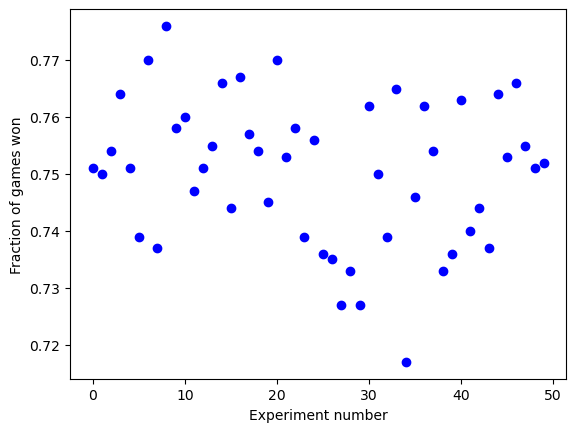

In [24]:
for k in range(50):
    TOTAL_SCORE = 0
    for _ in range(NUM_GAMES):
        TOTAL_SCORE += chsh_game(classical_strategy)
    plt.plot(k, TOTAL_SCORE / NUM_GAMES, 'bo')
    
plt.xlabel('Experiment number')
plt.ylabel('Fraction of games won')

Let us plot all together for better comparison

/var/folders/dp/bqxp8q3s61sfdwkbrxdklx3w0000gn/T/ipykernel_46164/1732525602.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();


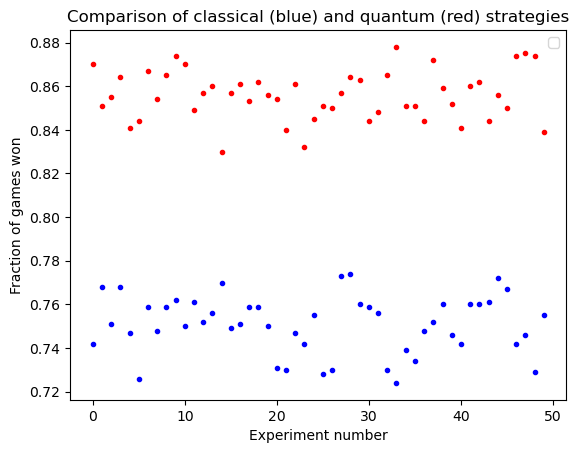

In [26]:
for k in range(50):
    TOTAL_SCORE_C = 0
    TOTAL_SCORE_Q = 0
    for _ in range(NUM_GAMES):
        TOTAL_SCORE_C += chsh_game(classical_strategy)
        TOTAL_SCORE_Q += chsh_game(quantum_strategy)
    plt.plot(k, TOTAL_SCORE_C / NUM_GAMES, 'b.')
    plt.plot(k, TOTAL_SCORE_Q / NUM_GAMES, 'r.')
    
plt.xlabel('Experiment number')
plt.ylabel('Fraction of games won')
plt.title('Comparison of classical (blue) and quantum (red) strategies')